In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
from sklearn.cross_validation import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split

C:\Users\86535\Anaconda3\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [4]:
def loc_id_cnt(num):
    df = pd.read_csv('./data/%02d.csv'%num)
    df_res = df.groupby(['time_stamp', 'loc_id']).agg({ 'phone_id':'count'})
    df_res.reset_index(inplace=True)
    return df_res

df = pd.DataFrame()
for i in range(10, 12):
    _df = loc_id_cnt(i)
    df = df.append(_df)

In [5]:
df = df[(df.time_stamp>='2017-10-09 00')]
#df = df[(df.time_stamp<'2017-07-10 00')]

In [6]:
def handle(df):
    # 时间维度
    df['datetime'] = df.time_stamp.apply(pd.to_datetime)
    del df['time_stamp']
    #df['month'] = df.datetime.apply(lambda x: x.month)
    df['day'] = df.datetime.apply(lambda x: x.day)
    df['hour'] = df.datetime.apply(lambda x: x.hour)
    df['weekday'] = df.datetime.apply(lambda x: x.weekday())
    df['weekend'] = df.datetime.apply(lambda x: int(x.weekday()>4))
    # 加入假期，节假日
    """
    def isSummer(x):
        if x > '2017-07-15 00:00:00' and x < '2017-09-03:00:00:00':
            return 1
        else:
            return 0

    def isSummerNear(x):
        if x > '2017-07-12 00:00:00' and x < '2017-07-15:00:00:00':
            return 1
        elif x > '2017-09-03 00:00:00' and x < '2017-09-06:00:00:00'::
            return 0 
    """
    def isHoliday(x):
        if x.date() == datetime.date(2017, 4, 4) or \
           x.date() == datetime.date(2017, 5, 1) or \
           x.date() == datetime.date(2017, 5, 30) or \
           x.date() == datetime.date(2017, 1, 1) or \
           x.date() >= datetime.date(2017, 10, 1) and x.date() <= datetime.date(2017, 10, 8):
            return 1
        else:
            return 0
    df['isHoliday'] = df.datetime.apply(isHoliday)
    return df
df = handle(df)

In [7]:
# load weather
def load_weather():
    w = pd.read_csv('weather.csv')
    w['datetime'] = (w.day.astype(str) + ' '+ w.time + ':00').apply(pd.to_datetime)
    del w['day']
    del w['time']
    w.head()
    return w
w = load_weather()

def handle_features(each, w):
    df1 = pd.merge(each, w, on='datetime', how='left')
    df1.weather.replace({u'晴天':1,
                         u'晴朗':1, 
                         u'局部多云':1,
                         u'多云': 1,
                         u'薄雾':3,
                         u'阴天':3,
                         u'周边零星小雨': 2,
                         u'细雨': 2,
                         u'小雨':2,
                         u'小雨夹雪':2,
                         u'零星细雨': 2,
                         u'零星小雨': 2,
                         u'小阵雨':2,
                         u'中雨': 4,
                         u'中到大阵雨': 4, 
                         u'周边雷暴': 4, 
                         u'零星雷雨': 4,
                         u'有时中雨': 4,
                         u'大雨': 5,
                         u'暴阵雨': 5,
                         u'中到大雷雨':5}, inplace=True)
    def handle_temp(x):
        if x < -5: return 1
        elif x < 5: return 2
        elif x < 15: return 3
        elif x < 25: return 4
        elif x< 35: return 5
        else: return 6
    df1['body_temp'] = df1.body_temp.apply(lambda x: float(x[:-1]))
    df1['temp'] = df1.temp.apply(lambda x: float(x[:-1]))
    df1['body_temp'] = df1['body_temp'].apply(handle_temp)
    df1['temp'] = df1['temp'].apply(handle_temp)
    df1['wind'] = df1.wind.apply(lambda x: float(x[:-1]) if x != '-' else 0)
    df1['shidu'] = df1.shidu.apply(lambda x: float(x[:-1]))
    df1['rain'] = df1.rain.apply(lambda x: float(x[:-2]) if x != '-' else 0)
    
    def oneHot(df1, col):
        from sklearn.preprocessing import OneHotEncoder
        enc = OneHotEncoder()
        ser = df1[col]
        enc.fit([[i] for i in ser])
        arr = enc.transform([[i] for i in ser]).toarray()
        concat_df = pd.DataFrame(arr, columns=[col+'_'+str(i) for i in range(1,len(arr[1])+1)])
        df = pd.concat([df1, concat_df],axis=1)
        del df[col]
        return df
    
    df1 = oneHot(df1, 'weather')
    df1 = oneHot(df1, 'body_temp')
    df1 = oneHot(df1, 'temp')
    return df1

loc_df = []
for i in range(1, 34):
    _df = df[df.loc_id==i]
    _df = handle_features(_df, w)
    _df.reset_index(inplace=True, drop=True)
    loc_df.append(_df)

In [16]:
def rmse(y_test, pred):
    return np.sqrt(np.mean(np.square(y_test.values - pred)))

In [33]:
loc_df[22]['phone_id'].head()

0    111
1    379
2    644
3    836
4    245
Name: phone_id, dtype: int64

In [34]:
def train_each_loc(locid):
    # 取一个地点的
    each = loc_df[locid]
    #each = replenish_miss_value_with_nan(each)
    X = each.dropna().iloc[:,3:]
    y = each.dropna()['phone_id']

    X_train,X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, random_state = 0)
    gbdt=GradientBoostingRegressor(
      loss='huber'
    , learning_rate=0.1
    , n_estimators=300
    , subsample=1
    , min_samples_split=2
    , min_samples_leaf=1
    , max_depth=3
    , init=None
    , random_state=None
    , max_features=None
    , alpha=0.9
    , verbose=0
    , max_leaf_nodes=None
    , warm_start=False
    )
    #try:
    gbdt.fit(X_train,y_train)
    #except:
    #    print(X_train, y_train)
    pred=gbdt.predict(X_test)
    print(rmse(y_test, pred))
    return gbdt

In [35]:
model_list = []
for locid in range(0, 33):
    print("************************loc id: ", locid+1)
    model = train_each_loc(locid)
    model_list.append(model)

************************loc id:  1
105.6587530237652
************************loc id:  2
136.3441272431546
************************loc id:  3
143.0339229093415
************************loc id:  4
81.73952703764118
************************loc id:  5
118.31269052374758
************************loc id:  6
113.43070779024588
************************loc id:  7
64.75763998195404
************************loc id:  8
397.5433285674354
************************loc id:  9
81.83141906270751
************************loc id:  10
395.1377658278231
************************loc id:  11
120.98471748953504
************************loc id:  12
510.16715105448833
************************loc id:  13
67.3111207521999
************************loc id:  14
80.27150768895945
************************loc id:  15
120.4131133266082
************************loc id:  16
110.5214785783805
************************loc id:  17
149.9415835308491
************************loc id:  18
110.28427701975274
************************loc id:  

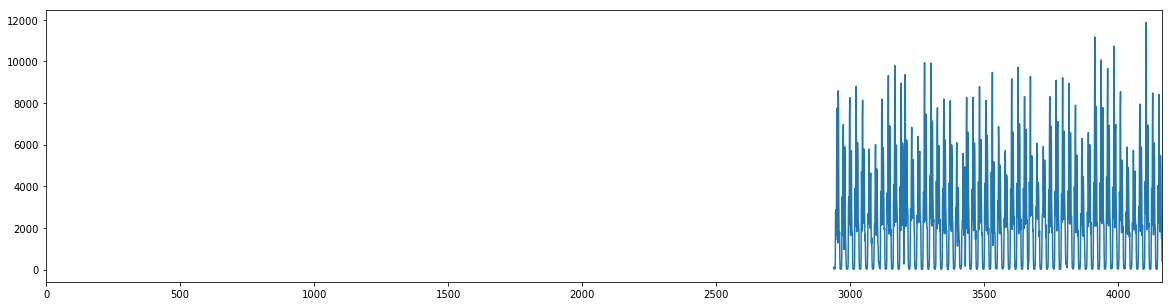

In [39]:
loc_df[11].phone_id.plot(figsize=(20,5))
plt.show()

In [220]:
fl = ['day', 'hour', 'weekday', 'weekend',
       'isHoliday', 'shidu', 'wind', 'rain', 'weather_1', 'weather_2',
       'weather_3', 'weather_4', 'weather_5', 'body_temp_1', 'body_temp_2',
       'body_temp_3', 'body_temp_4', 'body_temp_5', 'temp_1', 'temp_2',
       'temp_3', 'temp_4', 'temp_5']

nov = pd.DataFrame()
time_stamp_list = []
stamp = datetime.datetime(2017,11,1,0,0,0)
time_delta = datetime.timedelta(hours=1)
while stamp < datetime.datetime(2017,12,1,0,0,0):
    time_stamp_list.append(stamp)
    stamp += time_delta
nov['datetime'] = pd.Series(time_stamp_list)
nov['time_stamp'] = pd.Series(str(i)[:-6] for i in time_stamp_list)
nov = handle(nov)
nov = handle_features(nov, w)
novfl = nov.iloc[:,1:].columns
for col in (set(fl) - set(novfl)):
    nov[col] = 0

res = pd.DataFrame()
for loc_id, model in enumerate(model_list):
    model.predict(nov.iloc[:,1:])
    _df = pd.DataFrame()
    _df['loc_id'] = [loc_id+1 for _ in range(len(nov))]
    _df['time_stamp'] = pd.Series(str(i)[:-6] for i in time_stamp_list)
    _df['num_of_people'] = model.predict(nov.iloc[:,1:])
    res = res.append(_df)

In [235]:
len(res[res.num_of_people<0])/len(res)

0.024284511784511784

In [236]:
resNoZero = pd.DataFrame()
def helper(x):
    return x

for locid in range(1, 34):
    tmp = res[res.loc_id==locid]
    minNum = min(tmp.num_of_people)
    print(tmp['num_of_people'].quantile(0.05))
    tmp['num_of_people'] = tmp['num_of_people'].apply(helper)
    resNoZero = resNoZero.append(tmp)

151.97210465544154
198.59056939027118
32.864655451773565
59.05527689094405
108.8978108022748
56.81325543944435

C:\Users\86535\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':



26.426918079481872
-12.050137019099488
58.68552654511632
6.2862135744620575
135.75676127542715
40.65074557446089
18.588730029457587
13.699326892865036
2.097818835524133
-28.18803958628177
82.00747939274721
263.08791821231586
58.757055139964315
-3.610501320297126
126.0818351907181
2.4853240622862955
170.1928921431579
9.47947354217381
83.11665065977523
-7.584185090265076
-6.976882050101187
79.90141495846198
40.09091129215136
211.80514811762512
32.77926809654827
11.557822347464532
8.68220964188169


In [226]:
resNoZero = resNoZero.sort_values(['time_stamp','loc_id'])
resNoZero.to_csv('gbdt_res.csv', index=False)

In [227]:
resNoZero.head()

,loc_id,time_stamp,num_of_people
0,1,2017-11-01 00,155.249417
0,2,2017-11-01 00,212.224988
0,3,2017-11-01 00,152.642498
0,4,2017-11-01 00,74.411219
0,5,2017-11-01 00,212.973682


In [230]:
def adjust(x):
    if x>1000:
        return x+200
    elif x>500:
        return x+100
    elif x>0:
        return x
    else:
        return 5
resAdjust = pd.DataFrame()
resAdjust['loc_id'] = res.loc_id
resAdjust['time_stamp'] = res.time_stamp
resAdjust['num_of_people'] = res.num_of_people.apply(adjust)


resAdjust.to_csv('gbdt_resAdjust.csv', index=False)

In [239]:
20/500

0.04